In [1]:
# Project imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import os
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch import nn, optim
from sklearn.preprocessing import RobustScaler

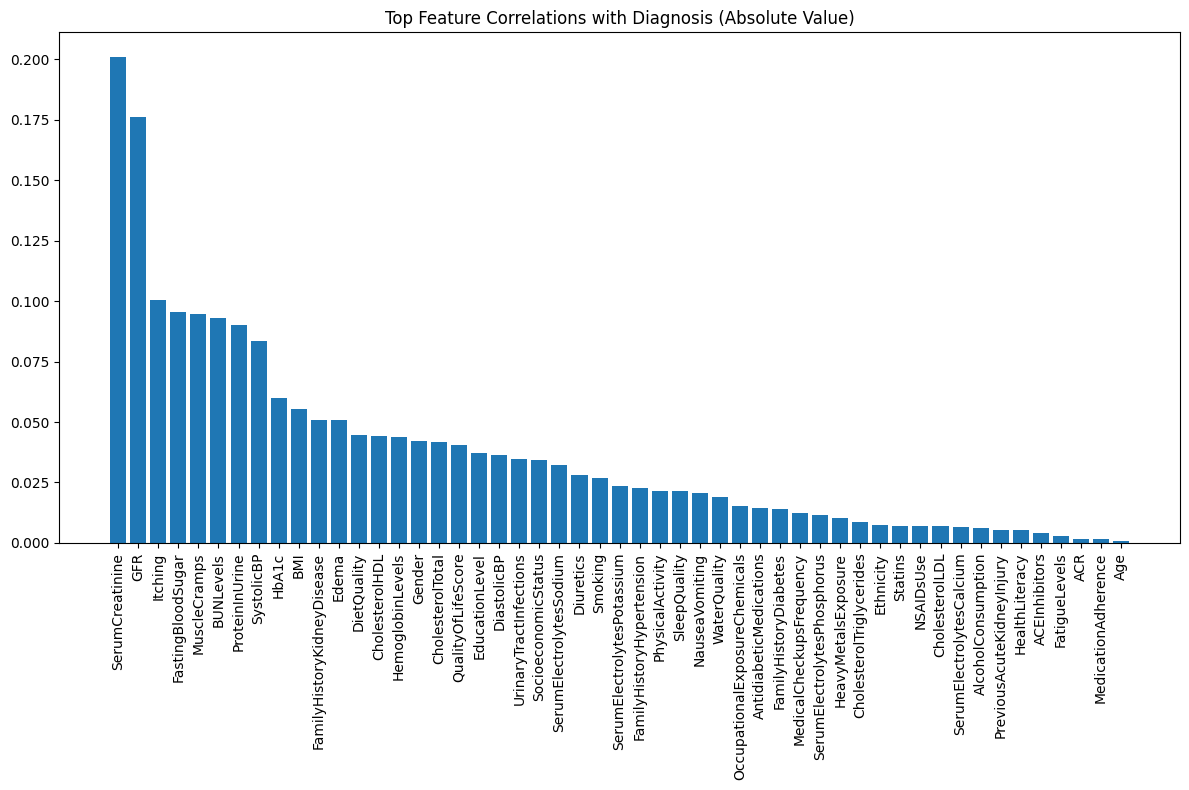


Top 10 Correlated Features with Diagnosis
SerumCreatinine: 0.2011
GFR: 0.1760
Itching: 0.1007
FastingBloodSugar: 0.0957
MuscleCramps: 0.0948
BUNLevels: 0.0931
ProteinInUrine: 0.0900
SystolicBP: 0.0835
HbA1c: 0.0600
BMI: 0.0552
Index(['SerumCreatinine', 'GFR', 'Itching', 'FastingBloodSugar',
       'MuscleCramps', 'BUNLevels', 'ProteinInUrine', 'SystolicBP', 'HbA1c',
       'BMI', 'Age', 'Gender', 'Diagnosis'],
      dtype='object')


In [2]:
# Load dataset and retrieve top 10 features. 

df = pd.read_csv("/kaggle/input/chronic-kidney-disease-dataset-analysis/Chronic_Kidney_Dsease_data.csv")

# Remove irrelevant columns, non-features
df = df.drop(columns=["PatientID", "DoctorInCharge"])
df = df.dropna()

# Separate features and target
y = df["Diagnosis"]
X = df.drop(columns=["Diagnosis"])

# Compute correlation of each feature with the target
correlations = X.corrwith(y).abs()
# Sort features by correlation
sorted_corr = correlations.sort_values(ascending=False)
mi = mutual_info_classif(X, y)
#for i, score in enumerate(mi):
    #print(f"{X.columns[i]}: {score}")


# Plot top features
plt.figure(figsize=(12, 8))
plt.title("Top Feature Correlations with Diagnosis (Absolute Value)")
plt.bar(range(len(sorted_corr)), sorted_corr.values)
plt.xticks(range(len(sorted_corr)), sorted_corr.index, rotation=90)
plt.tight_layout()
plt.show()


# Print top 10 features
print("\nTop 10 Correlated Features with Diagnosis")
top_10_features = sorted_corr.index[:10]
for feature in top_10_features:
    print(f"{feature}: {correlations[feature]:.4f}")


# Save a subset of the dataset with top features and metadata
selected_columns = list(top_10_features) + ["Age", "Gender", "Diagnosis"]
df_subset = df[selected_columns]
print(df_subset.columns)

Diagnosis
1    1524
0     135
Name: count, dtype: int64
Accuracy: 0.927710843373494

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.11      0.20        27
           1       0.93      1.00      0.96       305

    accuracy                           0.93       332
   macro avg       0.96      0.56      0.58       332
weighted avg       0.93      0.93      0.90       332


Confusion Matrix:
 [[  3  24]
 [  0 305]]


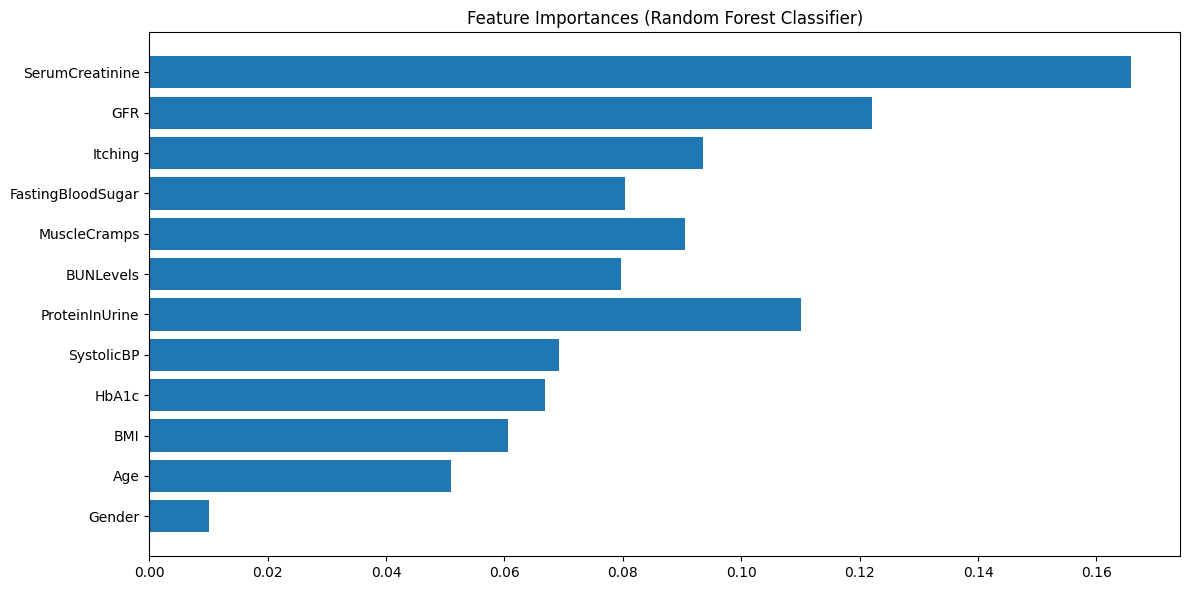

In [3]:
# Use RandomForestClassifier to perform binary classification (has CKD or not)


# Target is Diagnosis column (binary classification)
X = df_subset.drop(columns=["Diagnosis"])
y = df_subset["Diagnosis"]
print(y.value_counts())

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluation metrics of the model 
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Plot feature importances to see what features are most important in model decision making
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(12, 6))
plt.title("Feature Importances (Random Forest Classifier)")
plt.barh(feature_names, importances)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [4]:
# Separate features and label
label_col = "Diagnosis"
if label_col in df.columns:
    labels = df[label_col].values  # Save labels separately
    df_subset = df.drop(columns=[label_col])
else:
    labels = None
    df_subset = df.copy()

# Fit scaler on features
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_subset.values.astype(np.float32))

# Confirm shapes
print(f"Scaler scale_ shape: {scaler.scale_.shape}")  # Should be (number_of_features,)
print(f"Feature columns count: {len(df_subset.columns)}")
print(f"Shape of scaled data: {X_scaled.shape}")


Scaler scale_ shape: (51,)
Feature columns count: 51
Shape of scaled data: (1659, 51)


In [5]:
# Prepare dataset and dataloader
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

if labels is not None:
    labels_tensor = torch.tensor(labels, dtype=torch.int64)
    dataset = TensorDataset(X_tensor, labels_tensor)
else:
    dataset = TensorDataset(X_tensor)

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Number of training batches: {len(dataloader)}")
print(f"Input dimension: {X_tensor.shape[1]}")


Number of training batches: 52
Input dimension: 51


In [6]:
# Make the VAE

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        self.fc_decode1 = nn.Linear(latent_dim, 16)
        self.fc_out = nn.Linear(16, input_dim)
        self.relu = nn.ReLU()

    def encode(self, x):
        h = self.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc_decode1(z))
        return self.fc_out(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def loss_fn(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div


Epoch 50, Loss: 15.3778
Epoch 100, Loss: 15.3476
Epoch 150, Loss: 15.3207
Epoch 200, Loss: 15.3116
Epoch 250, Loss: 15.3625
Epoch 300, Loss: 15.3453


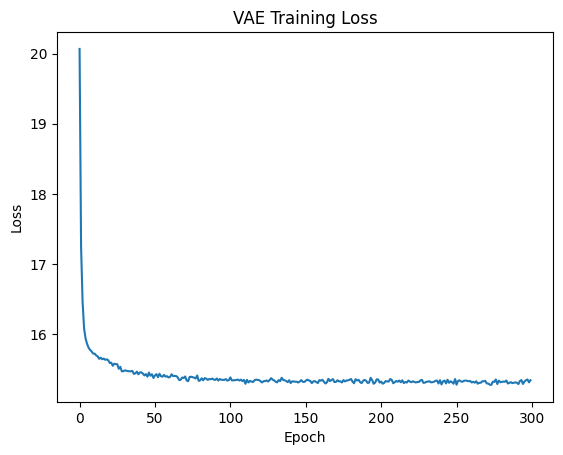

In [7]:
# Train VAE

device = torch.device("cpu")
vae = VAE(input_dim=X_tensor.shape[1], latent_dim=2).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)
epochs = 300
losses = []

for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = loss_fn(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataset)
    losses.append(avg_loss)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Plot training loss
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("VAE Training Loss")
plt.show()


In [8]:
# Save model

torch.save(vae.state_dict(), "vae.pth")
print("Model saved as 'vae.pth'")

Model saved as 'vae.pth'


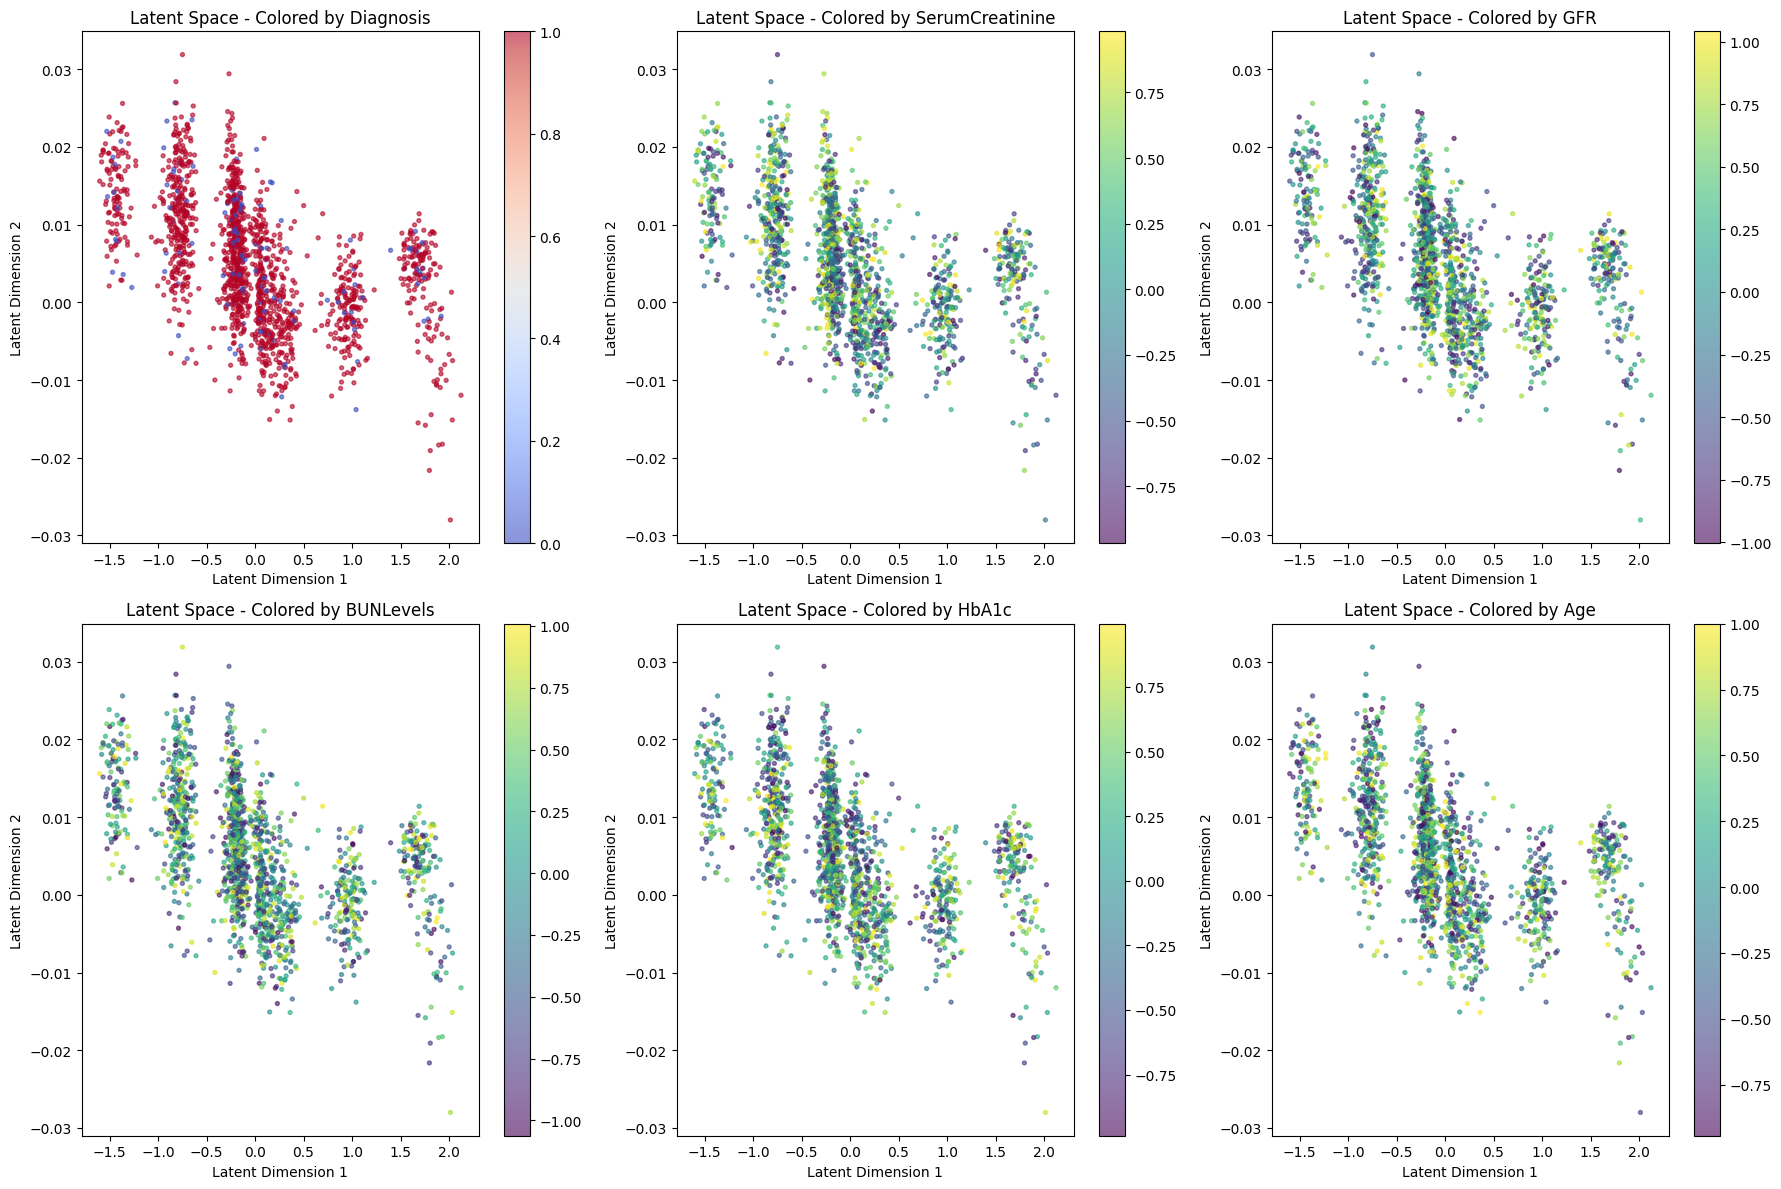

In [9]:
# Visualize latent space

import matplotlib.pyplot as plt

vae.eval()
with torch.no_grad():
    all_mu = []
    original_data = []

    for batch in dataloader:
        data = batch[0].to(device)
        mu, _ = vae.encode(data)
        all_mu.append(mu.cpu())
        original_data.append(data.cpu())

    mu_combined = torch.cat(all_mu, dim=0).numpy()
    original_combined = torch.cat(original_data, dim=0).numpy()

df_scaled = pd.DataFrame(original_combined, columns=df_subset.columns)

# Add back Diagnosis for coloring 
if labels is not None:
    df_scaled['Diagnosis'] = labels

colorby_features = ['Diagnosis', 'SerumCreatinine', 'GFR', 'BUNLevels', 'HbA1c', 'Age']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, feature in enumerate(colorby_features):
    if feature not in df_scaled.columns:
        continue
    scatter = axes[i].scatter(
        mu_combined[:, 0], mu_combined[:, 1],
        c=df_scaled[feature][:len(mu_combined)],
        cmap='coolwarm' if feature == 'Diagnosis' else 'viridis',
        s=8, alpha=0.6
    )
    axes[i].set_title(f'Latent Space - Colored by {feature}')
    axes[i].set_xlabel('Latent Dimension 1')
    axes[i].set_ylabel('Latent Dimension 2')
    plt.colorbar(scatter, ax=axes[i])

plt.tight_layout()
plt.show()


In [10]:
# Generate synthetic data

vae.eval()
with torch.no_grad():
    z_samples = torch.randn(10, 2)
    generated = vae.decode(z_samples).numpy()
    synthetic_data = scaler.inverse_transform(generated)
    print(pd.DataFrame(synthetic_data, columns=df_subset.columns))
    synthetic_df = pd.DataFrame(synthetic_data, columns=df_subset.columns)
    synthetic_df.to_csv("synthetic_data.csv", index=False)


         Age    Gender  Ethnicity  SocioeconomicStatus  EducationLevel  \
0  54.242100  0.495276   0.468413             0.989025        2.131024   
1  55.134247  0.524078   0.189165             1.009279        1.289973   
2  54.067142  0.493712   0.674475             0.980396        2.116677   
3  54.186008  0.493688   0.653639             0.985269        2.118727   
4  54.305817  0.507230   1.030818             0.970882        2.073926   
5  54.874355  0.514198   0.210894             1.006366        1.457252   
6  54.080235  0.552643   2.140522             0.884184        1.870456   
7  54.074635  0.490426   0.458162             0.989808        2.133374   
8  54.213196  0.532502   1.738145             0.928688        1.976879   
9  55.150208  0.522748   0.183928             1.010321        1.242472   

         BMI   Smoking  AlcoholConsumption  PhysicalActivity  DietQuality  \
0  27.809879  0.300754           10.265445          5.090228     4.992930   
1  27.692295  0.285882         